In [0]:
!pip install datashader
!pip install bokeh
!pip install holoviews
!pip install umap-learn
!pip install hdbscan

     |████████████████████████████████| 12.9MB 3.4MB/s 
     |████████████████████████████████| 71kB 26.4MB/s 
     |████████████████████████████████| 163kB 54.5MB/s 
     |████████████████████████████████| 81kB 29.4MB/s 
     |████████████████████████████████| 1.6MB 33.6MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59428 sha256=2a41e3ab6695d6a95c4b1417844456fd387cfe3a4a4457f563bf74c1d131ef2a
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4039 sha256=72d5c5960f36f57d23ca258d7aa85a570333fb7cf699caa6263b3a3e682e7c76
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built datashape locket
  Found existing installation: testpath 0.4.2
    Uninstalling testpath-0.4.2:
      Successfully uninstalled testpath-0.4.2
     |████████████████████████████████| 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 
import pandas as pd
import struct
import os
import json
import sys
import seaborn as sns 
from scipy import signal, stats

In [3]:
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

KeyboardInterrupt: ignored

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
!ls "/content/gdrive/My Drive/"

 Burst_data  'Colab Notebooks'


In [9]:
data_burst_by_time = np.load('/content/gdrive/My Drive/Burst_data/data_burst_by_time.npy')
data_burst_by_time_shuffled = (np.random.permutation(data_burst_by_time.T)).T
print("Averaged over channels: ", data_burst_by_time.shape)

Averaged over channels:  (3410, 13092)


In [10]:
data_burst_by_time = data_burst_by_time.T
print(data_burst_by_time.shape)

(13092, 3410)


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


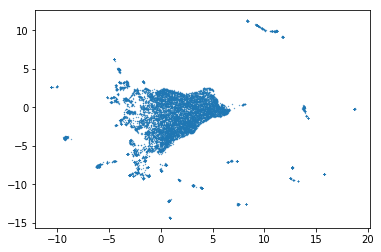

In [0]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(data_burst_by_time)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1,)

In [11]:
saved_A_sparse_files = [x for x in os.listdir('/content/gdrive/My Drive/Burst_data') if x.find("A_spars_neg") >= 0]
saved_A_sparse_files = np.sort(saved_A_sparse_files)
print(saved_A_sparse_files)
A_spars = np.load('/content/gdrive/My Drive/Burst_data/A_spars_neg13091.npy')
A_spars_non_neg = np.load(('/content/gdrive/My Drive/Burst_data/A_spars_13091.npy'))

['A_spars_neg13091.npy']


In [13]:
print(A_spars.shape)
print(A_spars_non_neg.shape)

(13092, 13092)
(13092, 13092)


In [0]:
COS = sklearn.metrics.pairwise.cosine_similarity(A_spars)
COS = np.maximum(np.zeros((COS.shape[0], COS.shape[1])), COS)
sorted_COS_indices = np.argsort(COS, axis = 1)

In [0]:
n = data_burst_by_time.shape[0]
NN = np.zeros((n,n)) # nonnegative sparsity induced similarity measure (NN) 
for i in range(n):
  if i%1000 == 0:
    print("Step: ", i)
  row_sum = np.sum(A_spars_non_neg[i])
  NN[i] = A_spars_non_neg[i]/row_sum

Step:  0
Step:  1000
Step:  2000
Step:  3000
Step:  4000
Step:  5000
Step:  6000
Step:  7000
Step:  8000
Step:  9000
Step:  10000
Step:  11000
Step:  12000
Step:  13000


In [17]:
saved_CSS_files = [x for x in os.listdir('/content/gdrive/My Drive/Burst_data') if x.find("CSS") >= 0]
saved_CSS_files = np.sort(saved_CSS_files)
print(saved_CSS_files)
CSS_checkpoint = np.load('/content/gdrive/My Drive/Burst_data/CSS60000000.npy')

['CSS60000000.npy']


In [0]:
import itertools

n = data_burst_by_time.shape[0]
combinations = itertools.combinations(range(n),2)
# convert the combination iterator into a numpy array
#combinations = np.array(list(results))

#combinations = itertools.islice(combinations,60000000)

In [0]:
#171.400.464
from numba import jit
@jit
def compute_CSS(n,combinations,A_spars,count=0,CSS_checkpoint=None):
  if CSS_checkpoint:
    CSS = CSS_checkpoint
  else:
    CSS = np.zeros((n,n)) # Consistent sign set
  #for i in range(n):
  #  if i%10000000 == 0:
  #    print("Step: ", i)
  #  for j in range(n):
  #    if not(i == j):
  #      xki = np.sign(np.delete(A_spars[i,:],[i,j]))
  #      xkj = np.sign(np.delete(A_spars[j,:],[i,j]))
  #      S =  np.where((xki == xkj) & (xki >0) & (xkj > 0))
  #      CSS[i,j] = len(S)/n
  #  if (i % 30000000 == 0 or i == n*n-1) and i > 0:
  #    np.save('/content/gdrive/My Drive/Burst_data/CSS' + str(i),CSS)
  #    print("Successfully saved CSS after %d steps" % i)
  count = count
  for c in combinations:
    i = c[0]
    j = c[1]
    xki = np.sign(np.delete(A_spars[i,:],[i,j]))
    xkj = np.sign(np.delete(A_spars[j,:],[i,j]))
    S =  np.where((xki == xkj) & (xki >0) & (xkj > 0))
    CSS[i,j] = len(S)/n
    CSS[j,i] = len(S)/n
    if count%10000000 == 0:
      print("Step: ", count)
      
    if count % 20000000 == 0  and count > 0:
      np.save('/content/gdrive/My Drive/Burst_data/CSS' + str(count),CSS)
      print("Successfully saved CSS after %d steps" % count)
    
    count += 1
  np.save('/content/gdrive/My Drive/Burst_data/CSS' + str(count),CSS)
  print("Successfully saved CSS after %d steps" % count)
  
  return CSS

In [25]:
n = data_burst_by_time.shape[0]
CSS = compute_CSS(n,combinations,A_spars)

Step:  0
Step:  10000000
Step:  20000000
Successfully saved CSS after 20000000 steps
Step:  30000000
Step:  40000000
Successfully saved CSS after 40000000 steps
Step:  50000000
Step:  60000000
Successfully saved CSS after 60000000 steps
Step:  70000000
Step:  80000000
Successfully saved CSS after 80000000 steps
Successfully saved CSS after 85693686 steps


In [0]:
clusterable_embedding = umap.UMAP(
    n_neighbors=20,
    min_dist=0.2,
    metric = "manhattan",
    n_components=3,
    random_state=42,
).fit_transform(data_burst_by_time)

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [0]:
clusterable_embedding

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='precomputed',
     metric_kwds=None, min_dist=0.0, n_components=3, n_epochs=None,
     n_neighbors=40, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [0]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

print(labels.shape)

(13092,)


In [0]:
clustered = (labels >= 0)
print(clustered.shape)

(13092,)


In [0]:
import pkgutil

package = umap
for importer, modname, ispkg in pkgutil.iter_modules(package.__path__):
    print("Found submodule %s (is a package: %s)" % (modname, ispkg))

Found submodule distances (is a package: False)
Found submodule nndescent (is a package: False)
Found submodule rp_tree (is a package: False)
Found submodule sparse (is a package: False)
Found submodule spectral (is a package: False)
Found submodule umap_ (is a package: False)
Found submodule utils (is a package: False)
Found submodule validation (is a package: False)


In [0]:
data_transformed = clusterable_embedding.transform(data_burst_by_time)

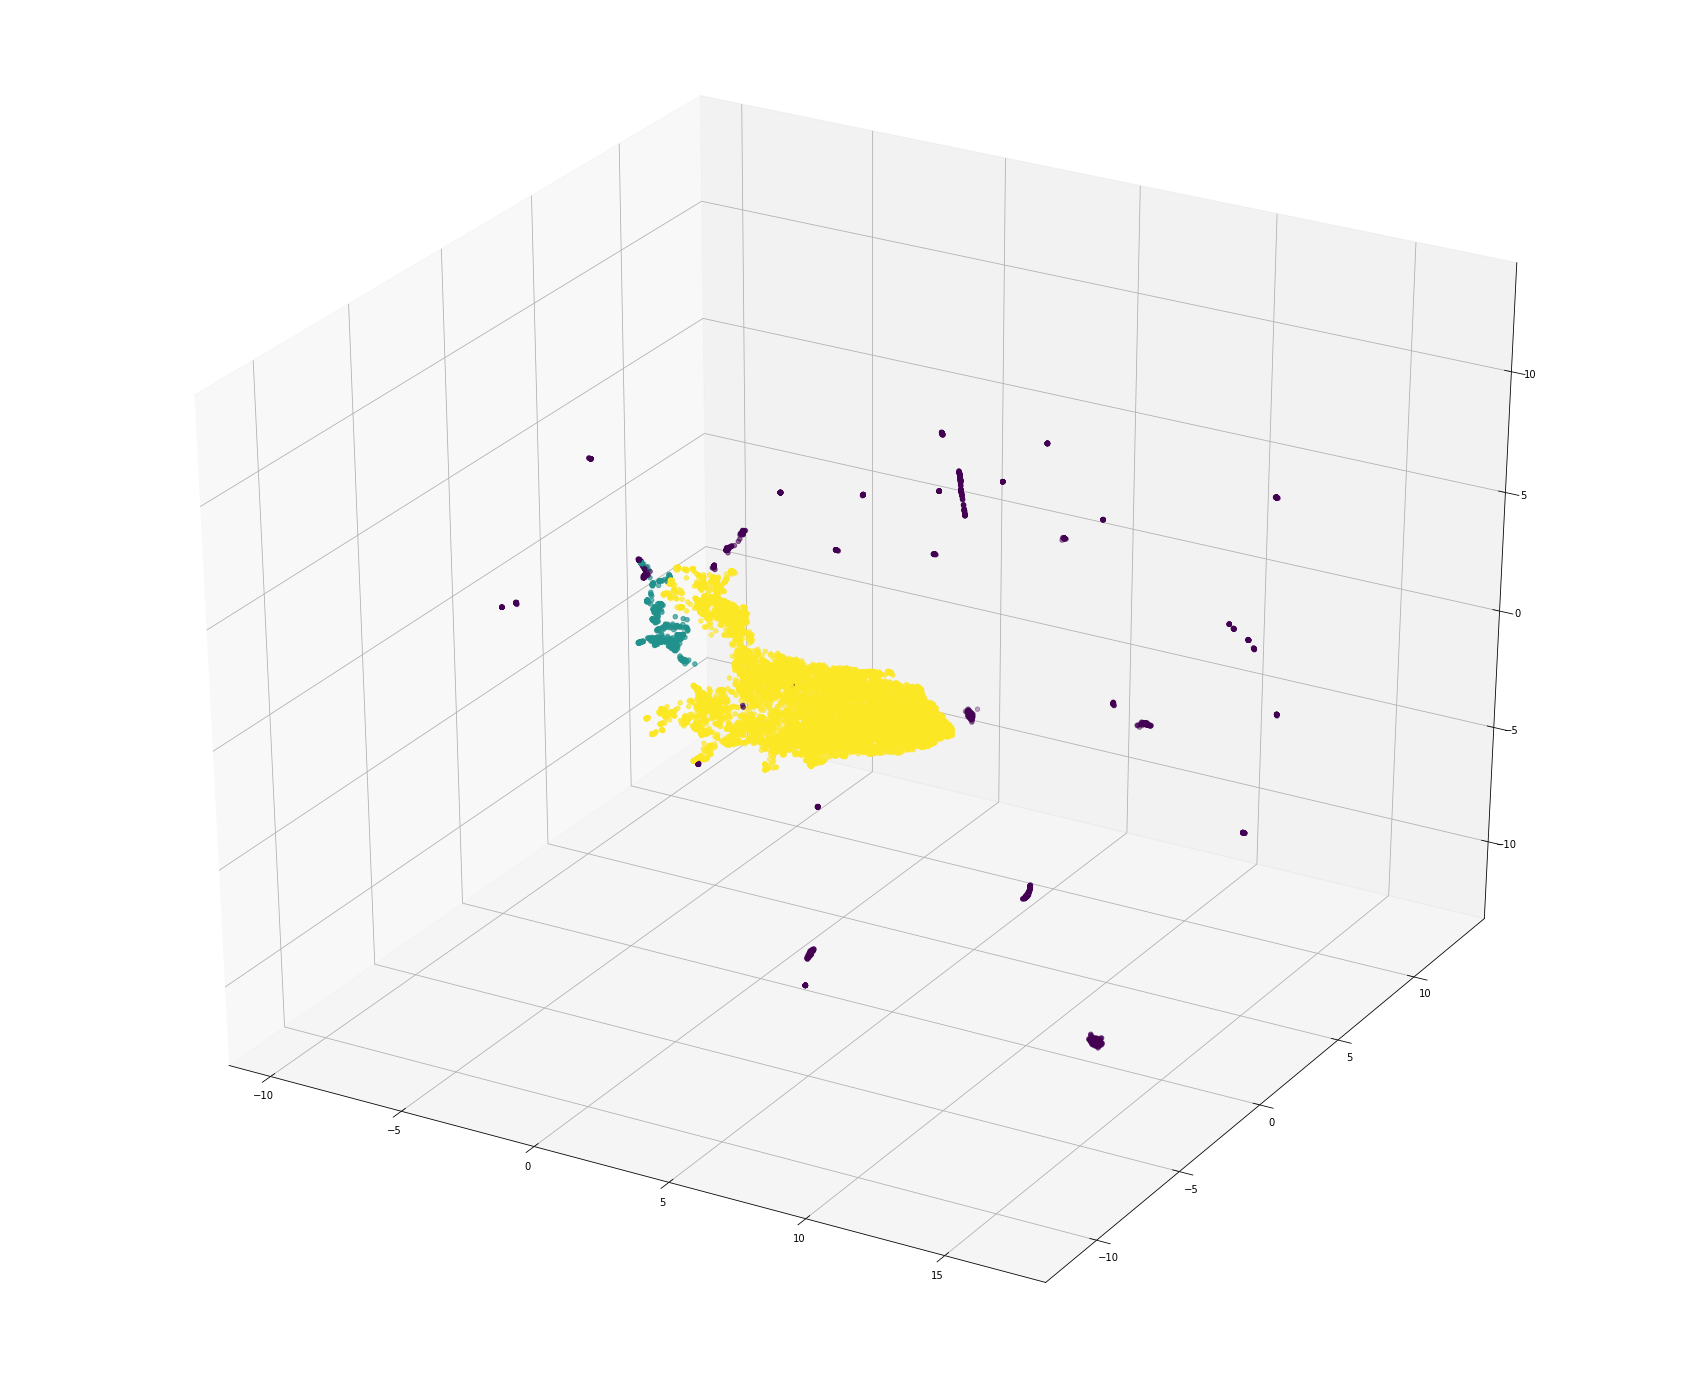

In [0]:
from mpl_toolkits.mplot3d import Axes3D 
#clustered = (labels >= 0)
fig = plt.figure(figsize = (30,25))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clusterable_embedding[:,0], clusterable_embedding[:,1], clusterable_embedding[:,2],c=labels)
plt.show()

In [0]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


[-1  0  1]
3


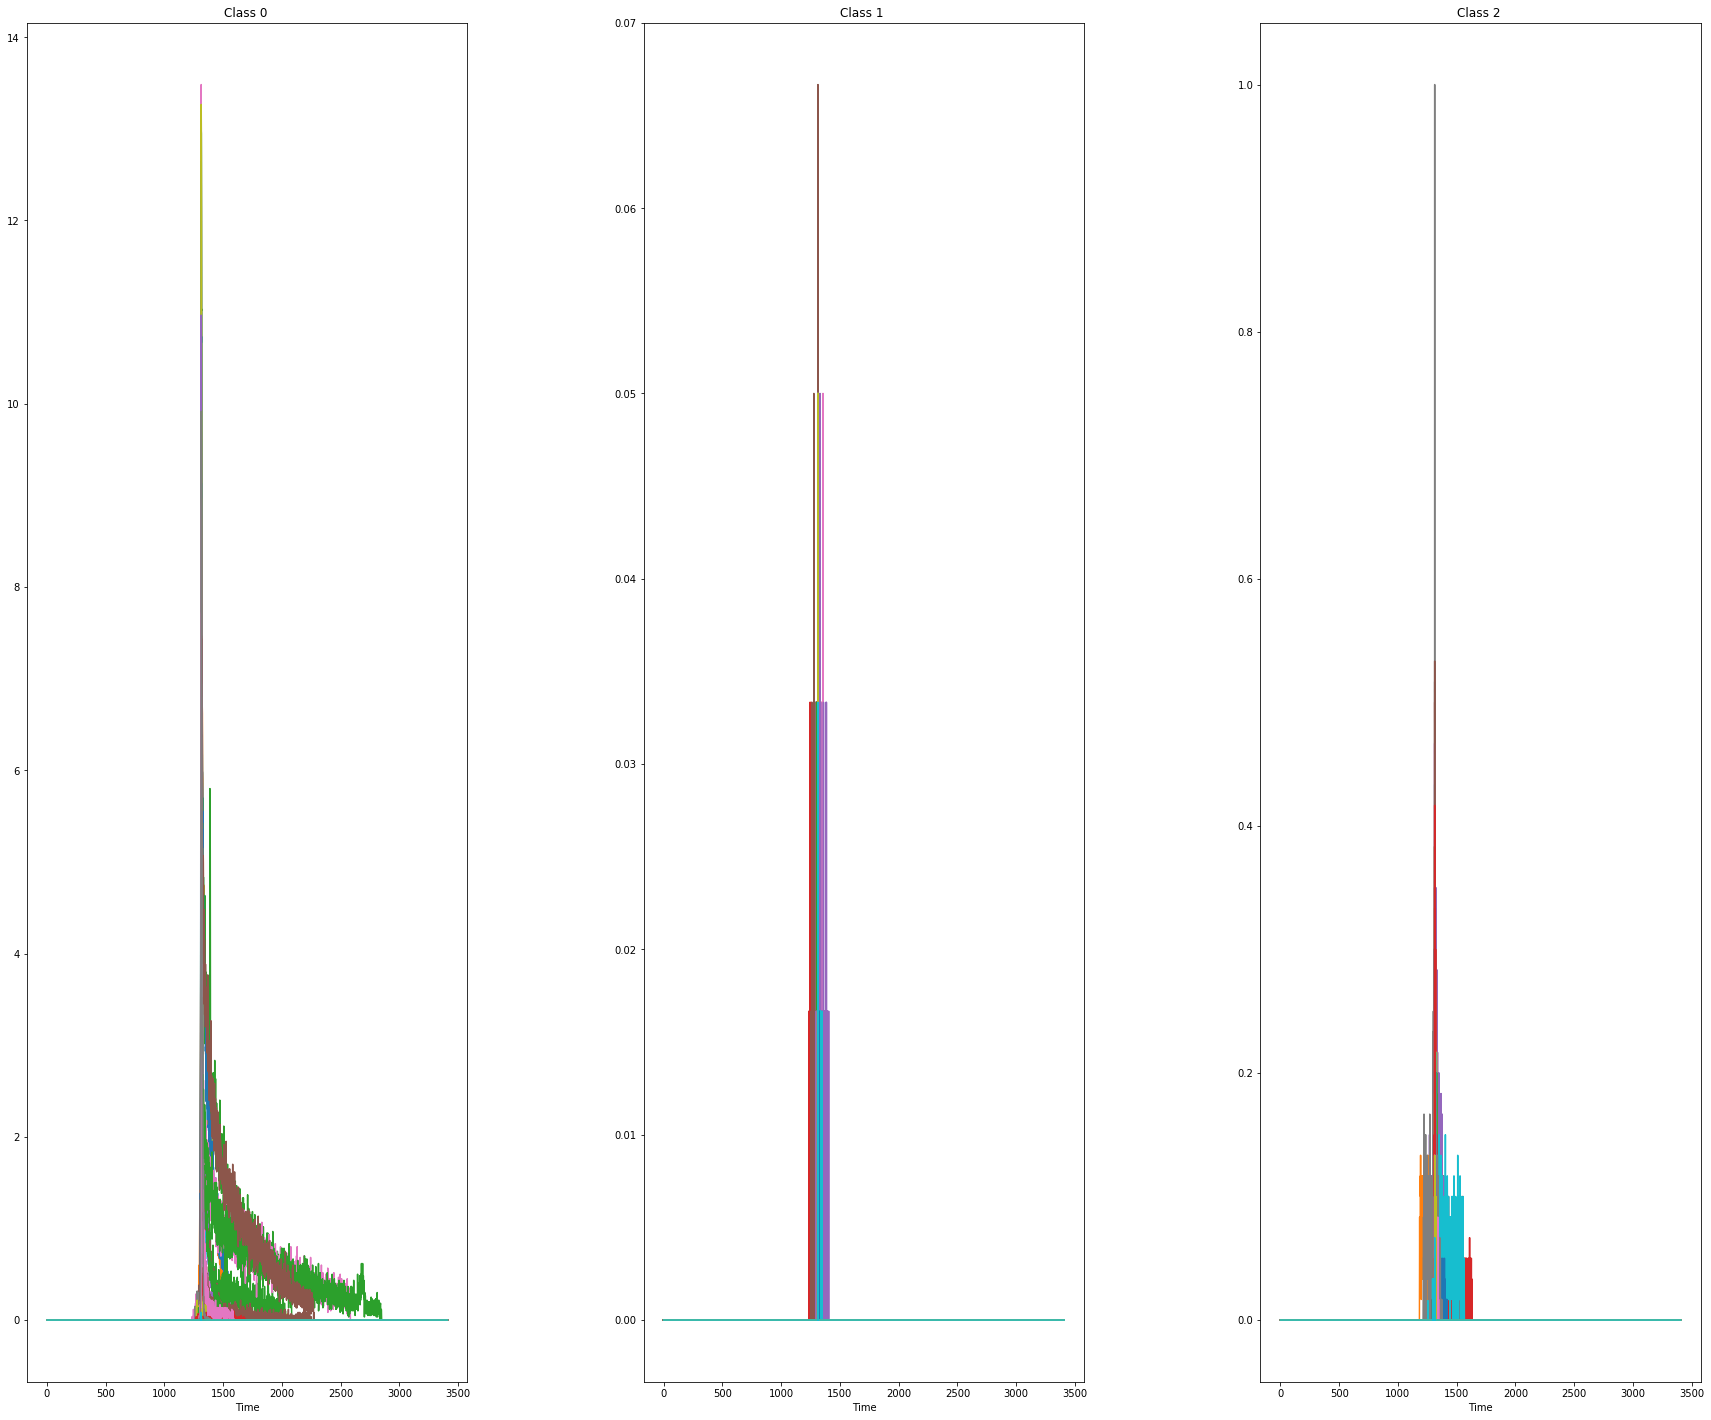

In [0]:
print(np.unique(labels))
labels = labels + 1
cutoff = len(np.unique(labels))
print(cutoff)
if cutoff < 10:
    colors = ["C" + str(i) for i in range(cutoff)]
else:
    colors = cm.rainbow(np.linspace(0, 1, cutoff))

fig = plt.figure(figsize=(30,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)    
rows = int(np.ceil(cutoff/3)) 
for i in np.unique(labels):
    class_i = data_burst_by_time[np.where(labels == i)]
    class_i = np.random.permutation(class_i)
    if i < cutoff:
        count = i + 1
    ax = fig.add_subplot(rows, 3, count)
    ax.set_xlabel("Time")
    ax.set_title("Class %i " % i)
    for burst in class_i[0:200]:
        ax.plot(burst)

In [0]:
from io import BytesIO
from PIL import Image
import base64

In [0]:
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis = 2 )
    return buf

In [0]:
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data(fig)
    w, h, d = buf.shape
    return Image.frombytes("RGBA",(w,h), buf.tostring( ))

In [0]:
def embeddable_image(fig):
    image = fig2img(fig)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [0]:
figs = []
for burst in data_burst_by_time[0:10]:
    plt.ioff()
    figure = plt.figure(figsize=(20,10))
    plt.plot(burst)
    figs.append(embeddable_image(fig)) 
    plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
